In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [35]:
def erro_relativo(df):
    operadores = [i for i in df.columns[1:-1]]
    for op in operadores:
        df[op] = (df[op] - df['Otimo']) / df['Otimo']
    return df

In [36]:
def box_plot(df, save=False):
    fig, ax = plt.subplots()
    ax.boxplot([df[col] for col in df.columns[1:-1]])
    ax.set_ylabel('Erro relativo')
    ax.set_xlabel('Operadores de crossover')
    plt.xticks([n for n in range(1, 13)], 
               ['Order-based', 'Position-based', 'PMX', 'One-point', 'Two-point', 'Two-point 2', 
                'OX2', 'Linear', 'Sequence-based', 'Loop-based', 'Two-cut PTL', 'Sem crossover'])
    plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right', fontsize='x-small')
    plt.grid(linewidth=0.4, axis='y')
    plt.plot()
    if save:
        plt.savefig('teste.jpg', dpi=300, bbox_inches='tight')

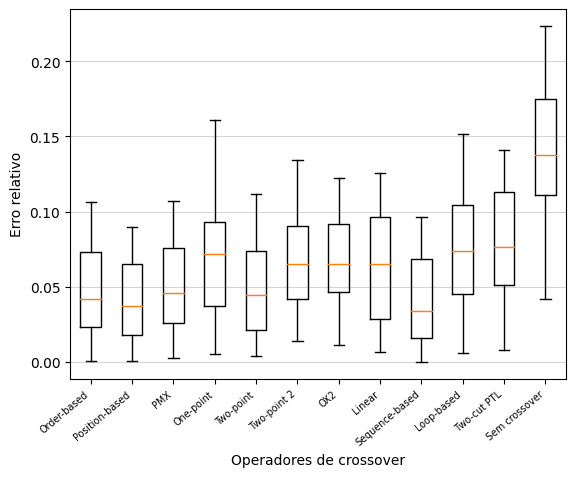

In [37]:
# Teste 1
df_1 = pd.read_csv('crossover_operators_124_120.csv', sep=';')
df_1 = erro_relativo(df_1)
box_plot(df_1[:], save=False)

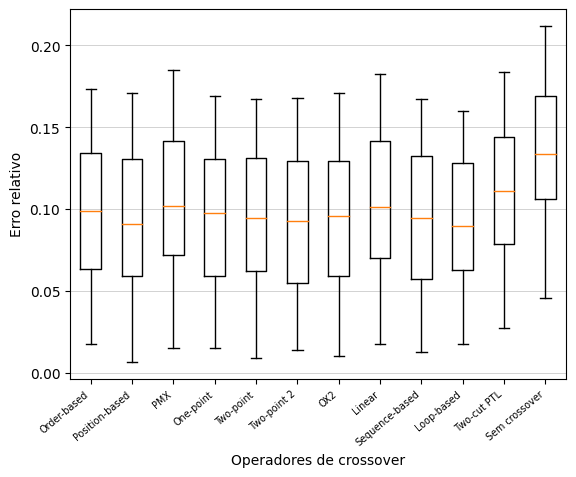

In [38]:
# Teste 2
df_2 = pd.read_csv('crossover_operators_163_11.csv', sep=';')
df_2 = erro_relativo(df_2)
box_plot(df_2[:], save=False)

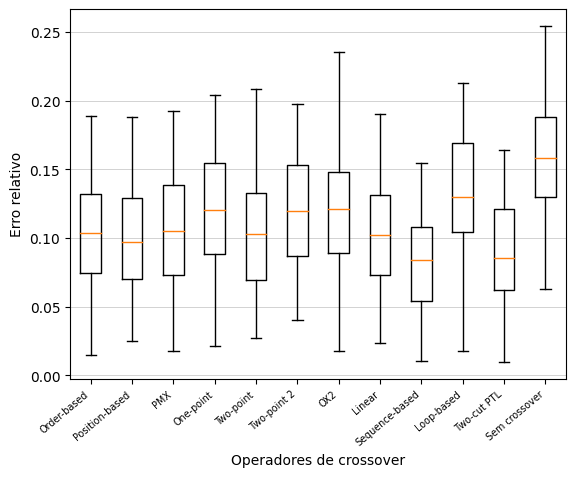

In [39]:
# Teste 3
df_3 = pd.read_csv('crossover_operators_18_133.csv', sep=';')
df_3 = erro_relativo(df_3)
box_plot(df_3[:], save=False)

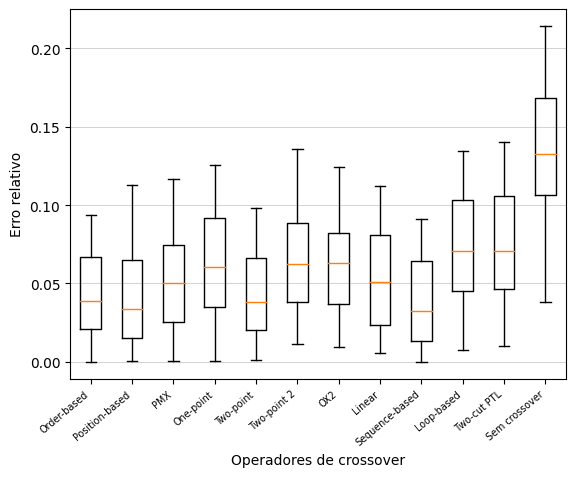

In [40]:
# Teste 4
df_4 = pd.read_csv('crossover_operators_194_133.csv', sep=';')
df_4 = erro_relativo(df_4)
box_plot(df_4[:], save=False)

[]

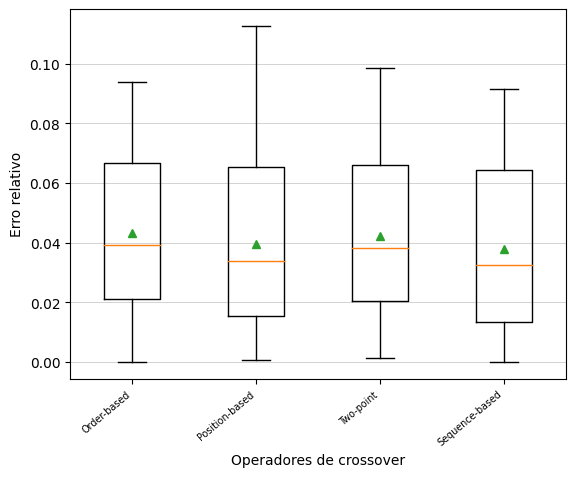

In [41]:
# Boxplot dos melhores operadores
best_ops = ['OrderBased', 'PositionBased', 'TwoPoint', 'SequenceBased']
fig, ax = plt.subplots()
ax.boxplot([df_4[col] for col in best_ops], showmeans=True)
ax.set_ylabel('Erro relativo')
ax.set_xlabel('Operadores de crossover')
plt.xticks([n for n in range(1, 5)], 
            ['Order-based', 'Position-based', 'Two-point', 'Sequence-based'])
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right', fontsize='x-small')
plt.grid(linewidth=0.4, axis='y')
plt.plot()
# plt.savefig('best.jpg', dpi=300, bbox_inches='tight')

In [42]:
# Dados dos tempos de processamento de cada operador
df_time = pd.read_csv('crossover_operators_time.csv', sep=';').drop(columns=['Otimo'])
df_time.head(5)

,Instancia,OrderBased,PositionBased,PMX,OnePoint,TwoPoint,TwoPointPermutation,OrderTwo,Linear,SequenceBased,LoopBased,TwoCutPTL,NoCross
0,20J_5M_0.txt,50.5474,54.0946,51.5138,49.6647,49.6797,51.8121,48.8824,47.8724,49.0853,48.0558,50.5361,46.2140
1,20J_10M_0.txt,56.6895,56.5909,54.8060,55.5260,55.5757,56.7972,56.9661,56.9285,55.1451,54.6763,53.7533,49.6191
2,20J_20M_0.txt,66.0512,67.0170,64.9628,64.9967,65.8408,66.0561,65.3573,65.8640,64.9937,64.9206,66.4365,62.7714
3,50J_5M_0.txt,58.1958,61.9830,57.2947,57.7754,58.0951,57.4073,57.5053,58.7490,56.2698,56.4002,57.2832,51.2712
4,50J_10M_0.txt,74.0070,76.6519,71.8573,72.2587,72.5813,85.8791,89.1584,88.9099,85.5600,85.2344,84.9672,72.8216


In [43]:
# Estatística descritiva dos tempos de processamento
df_time.describe()

,OrderBased,PositionBased,PMX,OnePoint,TwoPoint,TwoPointPermutation,OrderTwo,Linear,SequenceBased,LoopBased,TwoCutPTL,NoCross
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,165.508092,220.559600,163.964392,178.339150,184.097117,184.355975,187.807083,182.722033,180.744183,158.927708,164.078542,148.528433
std,190.755359,310.069978,184.982720,229.404074,243.623619,246.118782,262.467465,248.347580,246.380020,180.135449,183.198138,168.592782
min,50.547400,54.094600,51.513800,49.664700,49.679700,51.812100,48.882400,47.872400,49.085300,48.055800,50.536100,46.214000
25%,64.087350,65.758500,63.045775,63.191375,63.904375,63.893900,63.394300,64.085250,62.812725,62.790500,64.148175,59.896350
50%,99.791300,118.215950,99.698250,105.009300,107.860200,100.519350,100.038750,97.614900,94.827550,97.336400,98.867250,84.844450
75%,168.017100,198.763125,169.057525,168.178650,167.883675,166.243450,167.500625,165.671050,164.409050,161.640200,167.341825,150.968250
max,730.199400,1161.187000,708.247100,872.915100,925.148800,934.850200,992.644400,940.821600,932.565700,691.368700,703.222900,643.998900


In [44]:
# Download da estatística descritiva para o excel
# file_name = 'times.xlsx'
# df_time.describe().to_excel(file_name)